In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from matplotlib.cm import get_cmap

# Alltoall 

In [35]:
df_multinode = pd.read_csv("data/data-multi-defand100cflag.csv",delimiter = ",")
df_multinode['benchmark_type'].unique()
df_alltoall = df_multinode[df_multinode["benchmark_type"]=="Alltoall"][df_multinode['msg_size_bytes']>1024][df_multinode['off_cache_flag']==-1]
df_alltoall.columns.tolist()

/tmp/ipykernel_7900/2058266473.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_alltoall = df_multinode[df_multinode["benchmark_type"]=="Alltoall"][df_multinode['msg_size_bytes']>1024][df_multinode['off_cache_flag']==-1]
/tmp/ipykernel_7900/2058266473.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_alltoall = df_multinode[df_multinode["benchmark_type"]=="Alltoall"][df_multinode['msg_size_bytes']>1024][df_multinode['off_cache_flag']==-1]


['benchmark_type',
 'proc_num',
 'msg_size_bytes',
 'repetitions',
 't_min_usec',
 't_max_usec',
 't_avg_usec',
 'mpi_datatype',
 'mpi_red_datatype',
 'mpi_red_op',
 'creation_time',
 'n_nodes',
 'off_cache_flag']

/tmp/ipykernel_7900/4021581818.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('tab10')


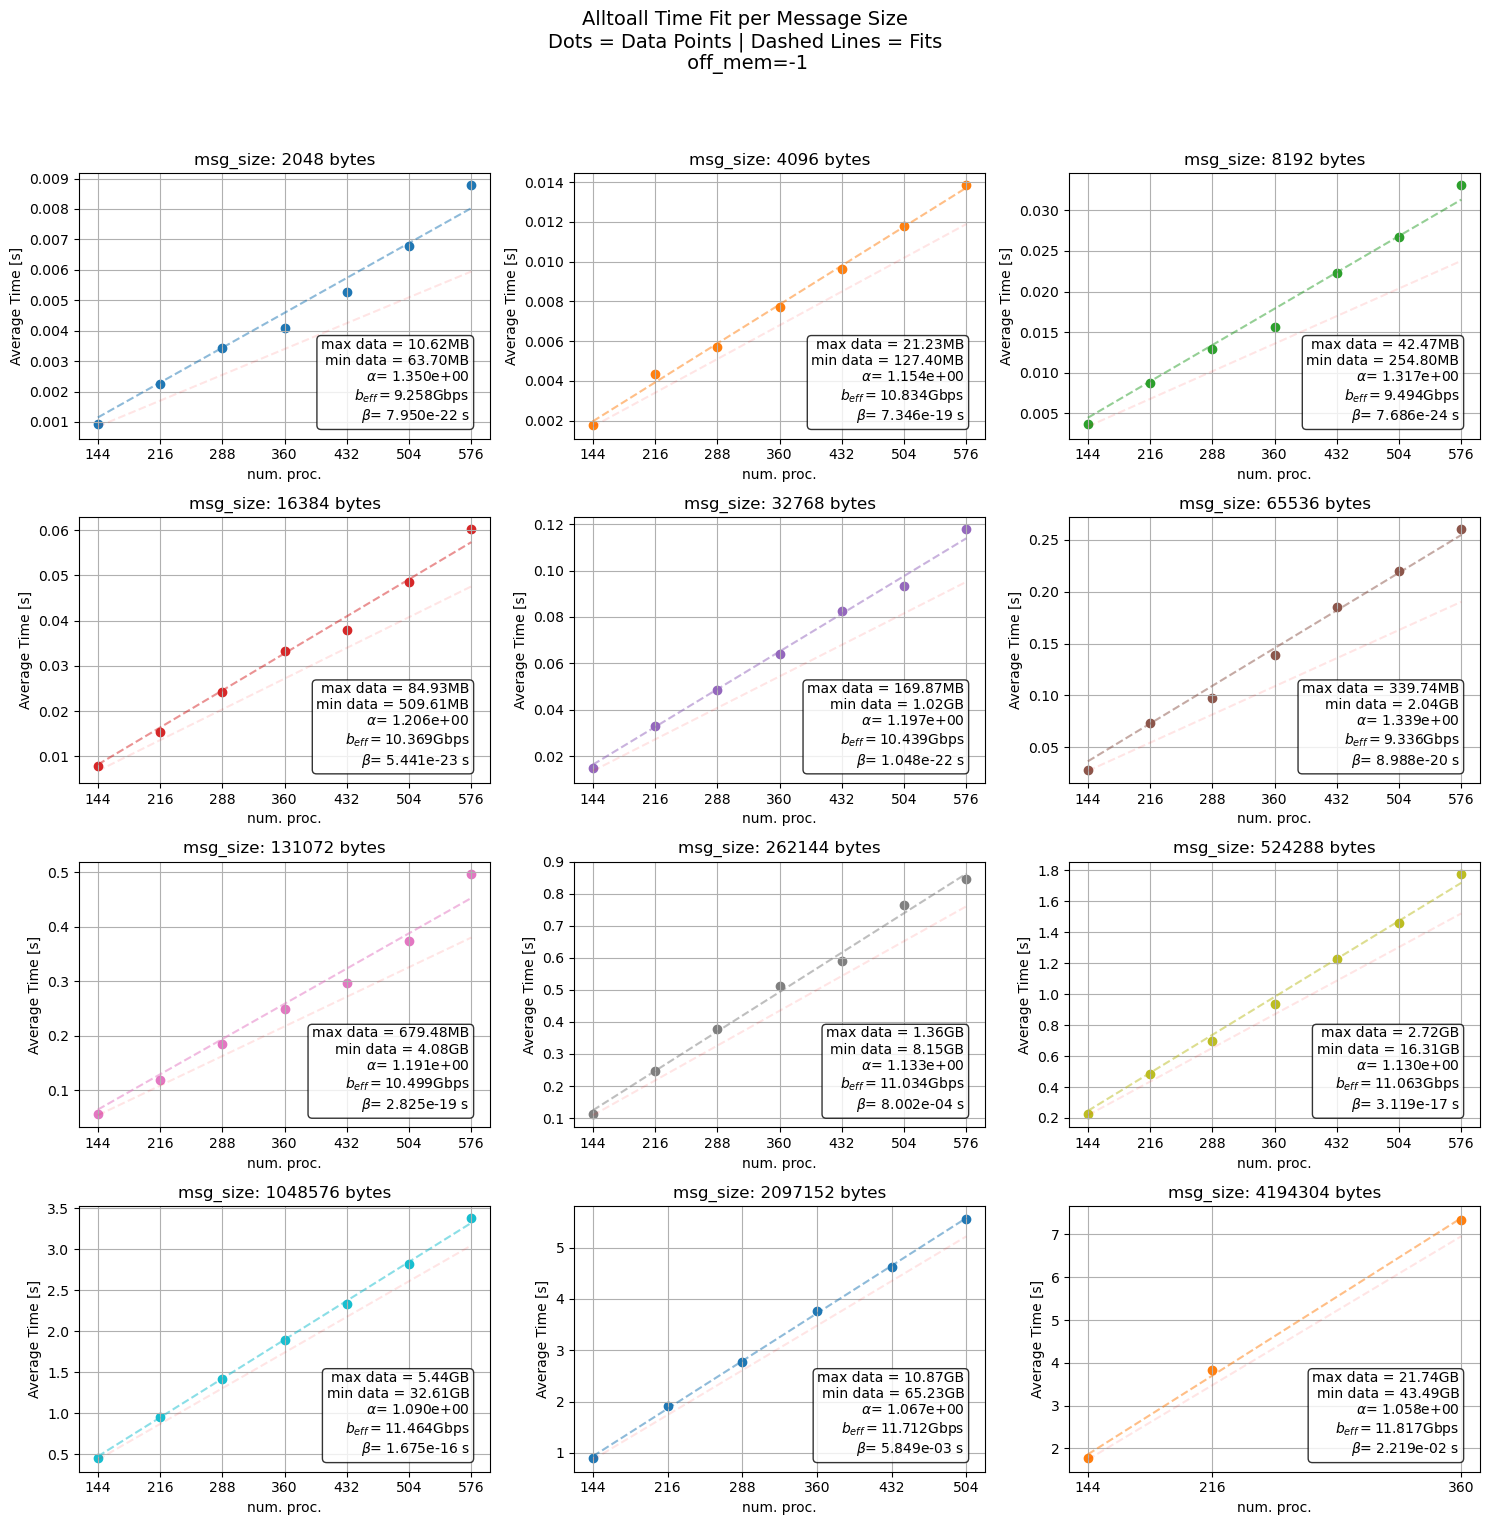

    msg_size_bytes     alpha          beta  inv_alpha
0             2048  1.350220  7.950002e-22   0.740620
1             4096  1.153722  7.345616e-19   0.866760
2             8192  1.316655  7.685776e-24   0.759501
3            16384  1.205501  5.440666e-23   0.829531
4            32768  1.197387  1.048284e-22   0.835152
5            65536  1.338850  8.987548e-20   0.746910
6           131072  1.190638  2.825286e-19   0.839886
7           262144  1.132900  8.001526e-04   0.882691
8           524288  1.129881  3.119047e-17   0.885049
9          1048576  1.090405  1.674706e-16   0.917091
10         2097152  1.067311  5.849285e-03   0.936934
11         4194304  1.057813  2.218755e-02   0.945346


In [38]:
def model(proc_num, alpha, beta, msg_size):
    return (alpha * msg_size * (proc_num - 72) * 72) / (12.5 * 1e3) + 1e6*beta

results = []
msg_sizes = sorted(df_alltoall['msg_size_bytes'].unique())
n_rows = int(np.ceil(len(msg_sizes) / 3))
n_cols = min(len(msg_sizes), 3)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows), squeeze=False)
cmap = get_cmap('tab10')

for idx, (msg_size, group) in enumerate(df_alltoall.groupby('msg_size_bytes')):
    x = group['proc_num'].values
    y = group['t_avg_usec'].values

    fit_func = lambda proc_num, alpha, beta: model(proc_num, alpha, beta, msg_size)
    popt, _ = curve_fit(fit_func, x, y, bounds=([1, 0], [np.inf, np.inf]))
    alpha, beta = popt
    results.append({'msg_size_bytes': msg_size, 'alpha': alpha, 'beta': beta})

    x_fit = np.linspace(min(x), max(x), 100)
    y_fit = fit_func(x_fit, alpha, beta)
    y_speed = model(x_fit,1,0,msg_size)
    row, col = divmod(idx, n_cols)
    ax = axes[row][col]

    color = cmap(idx % 10)
    ax.scatter(x, y/1e6, label='Data', color=color)
    ax.plot(x_fit, y_fit/1e6, linestyle='--', color=color, alpha=0.5, label='Fit')
    ax.plot(x_fit, y_speed/1e6, linestyle='--', color='red', alpha=0.1, label='Fit')
    ax.set_title(f'msg_size: {msg_size} bytes')
    ax.set_xlabel('num. proc.')
    ax.set_ylabel('Average Time [s]')
    ax.set_xticks(x)
    ax.grid(True)
    max_data =(x[-1]-72)*72*msg_size
    min_data =(x[0]-72)*72*msg_size

    textstr = ""
    if(max_data > 1e9):
        textstr+=f"max data = {max_data/1e9:0.2f}GB\n" 
    else:
        textstr+=f"max data = {max_data/1e6:0.2f}MB\n" 

    if(min_data > 1e9):
        textstr+=f"min data = {min_data/1e9:0.2f}GB\n" 
    else:
        textstr+=f"min data = {min_data/1e6:0.2f}MB\n" 
    textstr += r"$\alpha$" +f"= {alpha:.3e}\n"+r"$b_{eff}=$"+f"{12.5/alpha:0.3f}Gbps\n"+\
               r"$\beta$"+f"= {beta:.3e} s"
    ax.text(0.95, 0.05, textstr, transform=ax.transAxes,
            fontsize=10, verticalalignment='bottom',
            horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

fig.suptitle('Alltoall Time Fit per Message Size\nDots = Data Points | Dashed Lines = Fits\n off_mem=-1', fontsize=14)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("plots/alltoall_analysis.png",dpi=300)
plt.show()

fit_results = pd.DataFrame(results)
fit_results['inv_alpha'] = 1 / fit_results['alpha']
print(fit_results)


In [34]:
df_alltoall[df_alltoall['msg_size_bytes']==1048576]

benchmark_type  proc_num  msg_size_bytes  repetitions  t_min_usec  \
21         Alltoall       360         1048576           12  1887068.02   
69         Alltoall       576         1048576           12  3401545.19   
678        Alltoall       432         1048576           17  2400724.43   
906        Alltoall       216         1048576           15   979838.29   
2091       Alltoall       504         1048576           10  2855777.71   
2810       Alltoall       288         1048576           27  1414477.50   
3323       Alltoall       144         1048576           19   444484.16   

      t_max_usec  t_avg_usec mpi_datatype mpi_red_datatype mpi_red_op  \
21    1888622.38  1887741.99     MPI_BYTE        MPI_FLOAT    MPI_SUM   
69    3413244.99  3406651.76     MPI_BYTE        MPI_FLOAT    MPI_SUM   
678   2407984.77  2404588.58     MPI_BYTE        MPI_FLOAT    MPI_SUM   
906    985415.98   982015.14     MPI_BYTE        MPI_FLOAT    MPI_SUM   
2091  2866473.68  2857525.23     MPI_BYTE        MPI_FLOAT    MPI_SUM   
2810  1419906.99  1417331.44     MPI_BYTE        MPI_FLOAT    MPI_SUM   
3323   445342.60   444940.26     MPI_BYTE        MPI_FLOAT    MPI_SUM   

          creation_time  n_nodes  off_cache_flag  
21    25_07_27_02-42-36        5             100  
69    25_07_27_02-42-36        8             100  
678   25_07_27_02-42-36        6             100  
906   25_07_27_02-42-36        3             100  
2091  25_07_27_02-42-36        7             100  
2810  25_07_27_02-42-36        4             100  
3323  25_07_27_02-42-36        2             100